In [38]:
%pip install gurobipy

In [40]:
import pandas as pd
import numpy as np
from geopy.distance import great_circle
import random

def trip_distance(long1, lat1, long2, lat2):
  GPS1 = (long1, lat1)
  GPS2 = (long2, lat2)
  return 1.4413*great_circle(GPS1, GPS2).miles + 0.1383 #miles

data = pd.read_csv("data.csv")
data.drop(data.columns[0:8], axis=1, inplace = True)
data = data.rename(columns={"trip_time_in_secs": "trip_time_in_mins"}, inplace=False)
rows = data.index.tolist()
for r in rows:
  data['trip_time_in_mins'][r] = data['trip_time_in_mins'][r] / 60
  
customerFiles = 5
customerFilesRows = 500
taxiFiles = 5
taxiFilesRows = 300
safeBufferForCustomerFiles = 50
safeBufferForTaxiFiles = 30

cs_min = 0.2
cs_max = 1.2
cw_min = 1
cw_max = 20

soc_min = 0.1
soc_max = 1.0

for i in range(customerFiles + taxiFiles):
  if(i < customerFiles):
    df = data[(customerFilesRows + safeBufferForTaxiFiles)*i : (customerFilesRows + safeBufferForTaxiFiles)*(i+1)]
    request_index = df.index.tolist()
    idx = 1
    for index in request_index:
      df.loc[index,'trip_distance'] = round(trip_distance(df['pickup_longitude'][index], df['pickup_latitude'][index], 
                                                        df['dropoff_longitude'][index], df['dropoff_latitude'][index]), 3)
      if df['trip_distance'][index] < 0.5:
        df.drop(index, axis= 0, inplace= True)
        continue
      
      df.loc[index, 'customer_id'] = idx
      idx += 1
      df.loc[index, 'CS_distance'] = round(cs_min + (cs_max - cs_min)*random.random(), 3)
      df.loc[index,'customer_waiting_time_in_mins'] = round(cw_min + (cw_max - cw_min)*random.random(), 1)
    
    df = df.loc[:, ['customer_id', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','trip_distance', 'trip_time_in_mins', 'CS_distance', 'customer_waiting_time_in_mins']]
    df.drop(df.index[500:], inplace=True)
    df.to_csv(f'customer_trip_data_{i+1}_copy.csv', index=False)
    df.drop(df.index[50:], inplace=True)
    df.to_csv(f'customer_trip_data_{i+1}.csv', index=False)
  else:
    df = data[(taxiFilesRows + safeBufferForTaxiFiles)*i : (taxiFilesRows + safeBufferForTaxiFiles)*(i+1)]
    rows = df.index.tolist()
    for r in rows:
      df = df.rename(columns={"pickup_longitude": "taxi_longitude"}, inplace=False)
      df = df.rename(columns={"pickup_latitude": "taxi_latitude"}, inplace=False)

    df.drop('dropoff_longitude', axis= 1, inplace= True)
    df.drop('dropoff_latitude', axis= 1, inplace= True)
    df.drop('trip_time_in_mins', axis= 1, inplace= True)
    df.drop('trip_distance', axis= 1, inplace= True)
    taxi_index = df.index.tolist()
    idx = 1
    for index in taxi_index:
      df.loc[index, 'taxi_id'] = idx
      idx += 1
      df.loc[index, 'soc'] = round(soc_min + (soc_max - soc_min)*random.random(), 2)
    df = df.loc[:, ['taxi_id', 'taxi_longitude', 'taxi_latitude', 'soc']]
    df.drop(df.index[300:], inplace=True)
    df.to_csv(f'taxi_data_{i+1-customerFiles}_copy.csv', index=False)
    df.drop(df.index[30:], inplace=True)
    df.to_csv(f'taxi_data_{i+1}.csv', index=False)


C:\Users\siddh\AppData\Local\Temp\ipykernel_8656\3231621350.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['trip_time_in_mins'][r] = data['trip_time_in_mins'][r] / 60
C:\Users\siddh\AppData\Local\Temp\ipykernel_8656\3231621350.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'customer_id'] = idx
C:\Users\siddh\AppData\Local\Temp\ipykernel_8656\3231621350.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [42]:
%pip install gurobipy

Note: you may need to restart the kernel to use updated packages.


In [43]:
#test inputs
import pandas as pd
import numpy as np
import gurobipy
from gurobipy import Model, GRB, quicksum, tuplelist
from geopy.distance import great_circle
import math
import itertools
import random
import os
import shutil
from matplotlib import pyplot as plt
from copy import deepcopy

EAV_range = 200.0 #miles
avg_speed_NYC = 13.0 #mph
power_consumption_rate = 0.3 #kWh/mi
need_charging = 0.2 #SOC<20% range
charge_upto = 0.8 #charge upto 80%

max_pickup_time = 30.0 #minutes
max_pickup_dist = max_pickup_time*avg_speed_NYC/60 #miles
max_wait_time = 15.0
charging_power = 50.0 #kW

def trip_distance(long1, lat1, long2, lat2):
  GPS1 = (long1, lat1)
  GPS2 = (long2, lat2)
  return 1.4413*great_circle(GPS1, GPS2).miles + 0.1383 #miles

taxi = pd.read_csv('taxi_data_0.csv')
request = pd.read_csv('customer_trip_data_0.csv')

taxi_index = taxi.index.tolist()
request_index = request.index.tolist()
path = tuplelist(list(itertools.product(taxi_index, request_index)))
taxi = taxi.to_dict(orient="index")
request = request.to_dict(orient="index")

#pickup distance
pickup_distance = pd.DataFrame(index=taxi_index, columns=request_index)
pickup_distance = pickup_distance.to_dict(orient="index")
for each_taxi in taxi_index:
  for each_request in request_index:
    taxi_GPS = (taxi[each_taxi]['taxi_longitude'], taxi[each_taxi]['taxi_lattitude'])
    request_GPS = (request[each_request]['pickup_longitude'], request[each_request]['pickup_lattitude'])
    pickup_distance[each_taxi][each_request] = 1.4413*great_circle(taxi_GPS, request_GPS).miles + 0.1383 #miles

#pickup time
pickup_time_in_mins = deepcopy(pickup_distance)
for each_taxi in taxi_index:
  for each_request in request_index:
    pickup_time_in_mins[each_taxi][each_request] = int(math.ceil((pickup_distance[each_taxi][each_request]/avg_speed_NYC) * 60))
    
#pickup time + customer_waiting_time(mins)
delay_time_in_mins = deepcopy(pickup_time_in_mins)
for each_taxi in taxi_index:
  for each_request in request_index:
    delay_time_in_mins[each_taxi][each_request] = (pickup_time_in_mins[each_taxi][each_request]
            + request[each_request]['customer_waiting_time(mins)'])
    
#pickup distance + occupied distance dictionary
pickup_occupied_distance = deepcopy(pickup_distance)
for each_taxi in taxi_index:
  for each_request in request_index:
    pickup_occupied_distance[each_taxi][each_request] = pickup_distance[each_taxi][each_request] + request[each_request]['trip_distance']
            
#pickup distance + occupied distance + charging distance dictionary
pickup_occupied_CS_distance = deepcopy(pickup_distance)
for each_taxi in taxi_index:
  for each_request in request_index:
    pickup_occupied_CS_distance[each_taxi][each_request] = pickup_distance[each_taxi][each_request] + request[each_request]['trip_distance'] + request[each_request]['CS_distance']

#customer waiting time
eta = 1.0
customer_waiting_time = deepcopy(pickup_distance)
for each_taxi in taxi_index:
  for each_request in request_index:
    customer_waiting_time[each_taxi][each_request] = eta*request[each_request]['customer_waiting_time(mins)']

reward_function = deepcopy(pickup_distance)
for each_taxi in taxi_index:
  for each_request in request_index:
    reward_function[each_taxi][each_request] = max_pickup_time - pickup_time_in_mins[each_taxi][each_request] + customer_waiting_time[each_taxi][each_request]

print("pickup distance: ", pickup_distance)
print("pickup_time_in_mins: ", pickup_time_in_mins)
print("delay_time_in_mins: ", delay_time_in_mins)
print("pickup_occupied_distance: ", pickup_occupied_distance)
print("pickup_occupied_CS_distance: ", pickup_occupied_CS_distance)
print("customer_waiting_time: ", customer_waiting_time)
print("reward_function: ",  reward_function)

pickup distance:  {0: {0: 5.547343611349608, 1: 3.893885783695418, 2: 21.437816161663907, 3: 0.6072291448844135, 4: 1.168869801019022, 5: 0.8147962509402253, 6: 13.021483976066753, 7: 1.0738353656045938, 8: 5.213849073278436, 9: 1.308385205996032, 10: 5.426014940530678, 11: 1.8866026649042842, 12: 2.7353605962795355, 13: 0.7758774839375295, 14: 0.5560237136578089, 15: 0.9452021323609968, 16: 0.7985452781556286, 17: 3.512942167064851, 18: 4.034349010296177, 19: 13.336211676013084, 20: 4.339183777948428, 21: 1.0182188018602287, 22: 2.454954047919633, 23: 1.479695558917234, 24: 7.276821192932859, 25: 0.6866175446541108, 26: 5.133578029911542, 27: 1.0281820210189347, 28: 3.1731308780356913, 29: 4.545118557494209, 30: 4.636141945659649, 31: 1.5851439747642573, 32: 2.4386549838769542, 33: 0.942912387524201, 34: 4.123030927481753, 35: 5.0522927214047, 36: 0.6006715638939306, 37: 0.8976056886524736, 38: 3.3537319931649217, 39: 4.719794697269466, 40: 5.233923419669942, 41: 3.220278289273277, 42

In [44]:
#optimzation functions
import pandas as pd
import numpy as np
import gurobipy
from gurobipy import Model, GRB, quicksum, tuplelist
from geopy.distance import great_circle
import math
import itertools
import random
import os
import shutil
from matplotlib import pyplot as plt
from copy import deepcopy

EAV_range = 200.0 #miles
avg_speed_NYC = 13.0 #mph
power_consumption_rate = 0.3 #kWh/mi
need_charging = 0.2 #SOC<20% range
charge_upto = 0.8 #charge upto 80%

max_pickup_time = 30.0 #minutes
max_pickup_dist = max_pickup_time*avg_speed_NYC/60 #miles
max_wait_time = 15.0
charging_power = 50.0 #kW

def trip_distance(long1, lat1, long2, lat2):
  GPS1 = (long1, lat1)
  GPS2 = (long2, lat2)
  return 1.4413*great_circle(GPS1, GPS2).miles + 0.1383 #miles

taxi = pd.read_csv('taxi_data_0.csv')
request = pd.read_csv('customer_trip_data_0.csv')

taxi_index = taxi.index.tolist()
request_index = request.index.tolist()
path = tuplelist(list(itertools.product(taxi_index, request_index)))
taxi = taxi.to_dict(orient="index")
request = request.to_dict(orient="index")

#pickup distance
pickup_distance = pd.DataFrame(index=taxi_index, columns=request_index)
pickup_distance = pickup_distance.to_dict(orient="index")
for each_taxi in taxi_index:
  for each_request in request_index:
    taxi_GPS = (taxi[each_taxi]['taxi_longitude'], taxi[each_taxi]['taxi_lattitude'])
    request_GPS = (request[each_request]['pickup_longitude'], request[each_request]['pickup_lattitude'])
    pickup_distance[each_taxi][each_request] = 1.4413*great_circle(taxi_GPS, request_GPS).miles + 0.1383 #miles

#pickup time
pickup_time_in_mins = deepcopy(pickup_distance)
for each_taxi in taxi_index:
  for each_request in request_index:
    pickup_time_in_mins[each_taxi][each_request] = int(math.ceil((pickup_distance[each_taxi][each_request]/avg_speed_NYC) * 60))
    
#pickup time + customer_waiting_time(mins)
delay_time_in_mins = deepcopy(pickup_time_in_mins)
for each_taxi in taxi_index:
  for each_request in request_index:
    delay_time_in_mins[each_taxi][each_request] = (pickup_time_in_mins[each_taxi][each_request]
            + request[each_request]['customer_waiting_time(mins)'])
    
#pickup distance + occupied distance dictionary
pickup_occupied_distance = deepcopy(pickup_distance)
for each_taxi in taxi_index:
  for each_request in request_index:
    pickup_occupied_distance[each_taxi][each_request] = pickup_distance[each_taxi][each_request] + request[each_request]['trip_distance']
            
#pickup distance + occupied distance + charging distance dictionary
pickup_occupied_CS_distance = deepcopy(pickup_distance)
for each_taxi in taxi_index:
  for each_request in request_index:
    pickup_occupied_CS_distance[each_taxi][each_request] = pickup_distance[each_taxi][each_request] + request[each_request]['trip_distance'] + request[each_request]['CS_distance']

#customer waiting time
eta = 1.0
customer_waiting_time = deepcopy(pickup_distance)
for each_taxi in taxi_index:
  for each_request in request_index:
    customer_waiting_time[each_taxi][each_request] = eta*request[each_request]['customer_waiting_time(mins)']

reward_function = deepcopy(pickup_distance)
for each_taxi in taxi_index:
  for each_request in request_index:
    reward_function[each_taxi][each_request] = max_pickup_time - pickup_time_in_mins[each_taxi][each_request] + customer_waiting_time[each_taxi][each_request]

model = Model()
model.setParam('OutputFlag', 0)

#variables
x = model.addVars(taxi_index, request_index, vtype=GRB.BINARY, name="x")
obj = quicksum(x[i,j]*reward_function[i][j] for i,j in path)
model.setObjective(obj, GRB.MAXIMIZE)

#add constraints
for each_taxi in taxi_index:
  for each_request in request_index:
    if (pickup_occupied_CS_distance[each_taxi][each_request]>(taxi[each_taxi]['soc']*EAV_range)):
      model.addConstr(x[each_taxi, each_request]==0) #taxi does not accept request if range is not enough
    if(pickup_time_in_mins[each_taxi][each_request] > max_pickup_time):
      model.addConstr(x[each_taxi, each_request] == 0) #taxi does not accept request if pickup time is more than max
    if(customer_waiting_time[each_taxi][each_request] > max_wait_time):
      model.addConstr(x[each_taxi, each_request]==0) #taxi does not accept request if waiting time is more than max

model.addConstrs(x.sum(i, '*')<=1 for i in taxi_index)
model.addConstrs(x.sum('*', j)<=1 for j in request_index)
    
#solve
model.optimize()
#print solution
for v in model.getVars():
  if v.x == 1.0:
    print(v.varName, v.x)
print('Obj:', model.objVal)

x[0,3] 1.0
x[1,46] 1.0
x[2,7] 1.0
x[4,1] 1.0
x[5,30] 1.0
x[6,43] 1.0
x[7,11] 1.0
x[8,36] 1.0
x[9,34] 1.0
x[10,35] 1.0
x[11,16] 1.0
x[12,38] 1.0
x[13,19] 1.0
x[14,24] 1.0
x[15,10] 1.0
x[16,47] 1.0
x[17,40] 1.0
x[18,4] 1.0
x[19,23] 1.0
x[20,29] 1.0
x[21,13] 1.0
x[22,17] 1.0
x[23,8] 1.0
x[24,28] 1.0
x[25,27] 1.0
x[26,0] 1.0
x[27,9] 1.0
x[28,32] 1.0
x[29,49] 1.0
Obj: 1010.4000000000001


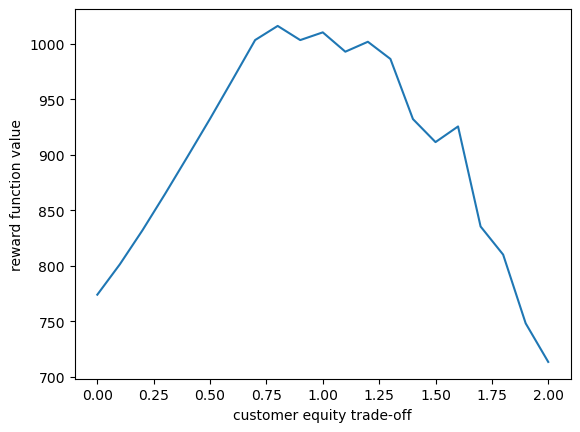

In [45]:
#analysis - reward fxn vs eta
eta_list = np.round_(np.arange(0, 2.1, 0.1).tolist(), decimals = 2)
obj_function_val = np.array([])

for eta in eta_list:
  customer_waiting_time = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      customer_waiting_time[each_taxi][each_request] = eta*request[each_request]['customer_waiting_time(mins)'] 

  reward_function = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      reward_function[each_taxi][each_request] = max_pickup_time - pickup_time_in_mins[each_taxi][each_request] + customer_waiting_time[each_taxi][each_request]

  model = Model()
  model.setParam('OutputFlag', 0)

  #variables
  x = model.addVars(taxi_index, request_index, vtype=GRB.BINARY, name="x")
  obj = quicksum(x[i,j]*reward_function[i][j] for i,j in path)
  model.setObjective(obj, GRB.MAXIMIZE)

  for each_taxi in taxi_index:
    for each_request in request_index:
      if (pickup_occupied_CS_distance[each_taxi][each_request]>(taxi[each_taxi]['soc']*EAV_range)):
        model.addConstr(x[each_taxi, each_request]==0) #taxi does not accept request if range is not enough
      if(pickup_time_in_mins[each_taxi][each_request] > max_pickup_time):
        model.addConstr(x[each_taxi, each_request] == 0) #taxi does not accept request if pickup time is more than max
      if(customer_waiting_time[each_taxi][each_request] > max_wait_time):
        model.addConstr(x[each_taxi, each_request]==0) #taxi does not accept request if waiting time is more than max

  model.addConstrs(x.sum(i, '*')<=1 for i in taxi_index)
  model.addConstrs(x.sum('*', j)<=1 for j in request_index)

  #solve
  model.optimize()
  # print('Obj:', model.objVal)
  obj_function_val = np.append(obj_function_val, model.objVal)

plt.plot(eta_list, obj_function_val)
plt.xlabel("customer equity trade-off")
plt.ylabel("reward function value")
plt.show()

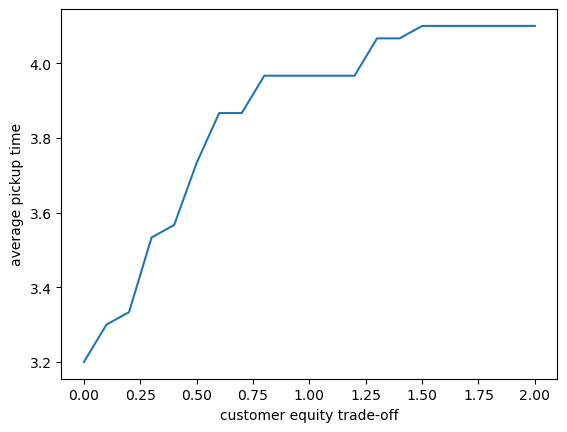

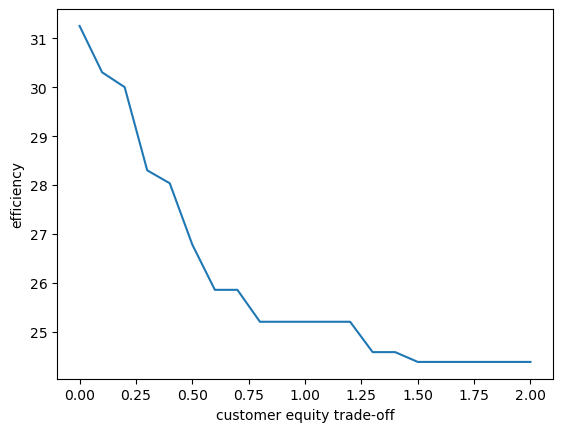

In [46]:
#analysis - eta vs efficiency
eta_list = np.round_(np.arange(0, 2.1, 0.1).tolist(), decimals = 2)
efficiency = np.array([])
pickup_time = np.array([])

for eta in eta_list:
  customer_waiting_time = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      customer_waiting_time[each_taxi][each_request] = eta*request[each_request]['customer_waiting_time(mins)'] 

  reward_function = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      reward_function[each_taxi][each_request] = max_pickup_time - pickup_time_in_mins[each_taxi][each_request] + customer_waiting_time[each_taxi][each_request]

  model = Model()
  model.setParam('OutputFlag', 0)

  #variables
  x = model.addVars(taxi_index, request_index, vtype=GRB.BINARY, name="x")
  obj = quicksum(x[i,j]*reward_function[i][j] for i,j in path)
  model.setObjective(obj, GRB.MAXIMIZE)

  #add constraints
  for each_taxi in taxi_index:
    for each_request in request_index:
      if (pickup_occupied_CS_distance[each_taxi][each_request]>(taxi[each_taxi]['soc']*EAV_range)):
        model.addConstr(x[each_taxi, each_request]==0) #taxi does not accept request if range is not enough
      if(pickup_time_in_mins[each_taxi][each_request] > max_pickup_time):
        model.addConstr(x[each_taxi, each_request] == 0) #taxi does not accept request if pickup time is more than max
      # if(customer_waiting_time[each_taxi][each_request] > max_wait_time):
      #   model.addConstr(x[each_taxi, each_request]==0)

  model.addConstrs(x.sum(i, '*')<=1 for i in taxi_index)
  model.addConstrs(x.sum('*', j)<=1 for j in request_index)

  #solve
  model.optimize()
  # print('Obj:', model.objVal)

  total_pickup_time = 0.0
  for v in model.getVars():
    if v.x == 1.0:
      str = v.varName
      total_pickup_time += pickup_time_in_mins[int((str.split(',')[0]).split('[')[1])][int((str.split(',')[1]).split(']')[0])]
  
  avg_pickup_time = 0.0
  avg_pickup_time = (total_pickup_time)/(len(taxi_index))

  pickup_time = np.append(pickup_time, avg_pickup_time)

plt.plot(eta_list, pickup_time)
plt.xlabel("customer equity trade-off")
plt.ylabel("average pickup time")
plt.show()

efficiency = (1/pickup_time) * 100
plt.plot(eta_list, efficiency)
plt.xlabel("customer equity trade-off")
plt.ylabel("efficiency")
plt.show()

C:\Users\siddh\AppData\Local\Temp\ipykernel_8656\3664106529.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return total / (len(x)**2 * np.mean(x))


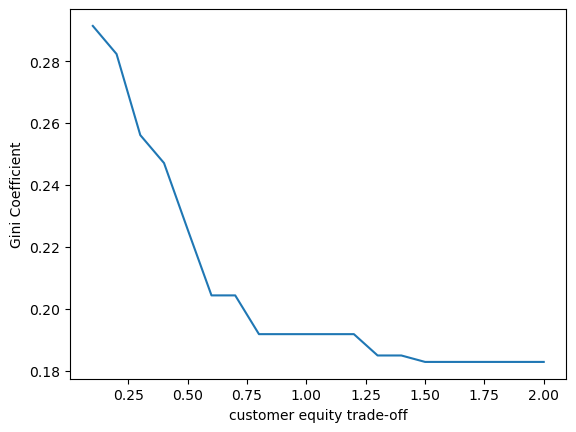

In [47]:
#analysis - gini coefficient(Lorenz Curve)
#analysis - eta vs efficiency
eta_list = np.round_(np.arange(0, 2.1, 0.1).tolist(), decimals = 2)
gini_coefficient = np.array([])

#reference: https://www.statology.org/gini-coefficient-python/
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

for eta in eta_list:
  customer_waiting_time_distribution = np.array([])
  
  customer_waiting_time = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      customer_waiting_time[each_taxi][each_request] = eta*request[each_request]['customer_waiting_time(mins)'] 

  reward_function = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      reward_function[each_taxi][each_request] = max_pickup_time - pickup_time_in_mins[each_taxi][each_request] + customer_waiting_time[each_taxi][each_request]

  model = Model()
  model.setParam('OutputFlag', 0)

  #variables
  x = model.addVars(taxi_index, request_index, vtype=GRB.BINARY, name="x")
  obj = quicksum(x[i,j]*reward_function[i][j] for i,j in path)
  model.setObjective(obj, GRB.MAXIMIZE)

  #add constraints
  for each_taxi in taxi_index:
    for each_request in request_index:
      if (pickup_occupied_CS_distance[each_taxi][each_request]>(taxi[each_taxi]['soc']*EAV_range)):
        model.addConstr(x[each_taxi, each_request]==0) #taxi does not accept request if range is not enough
      if(pickup_time_in_mins[each_taxi][each_request] > max_pickup_time):
        model.addConstr(x[each_taxi, each_request] == 0) #taxi does not accept request if pickup time is more than max
      # if(customer_waiting_time[each_taxi][each_request] > max_wait_time):
      #   model.addConstr(x[each_taxi, each_request]==0)

  model.addConstrs(x.sum(i, '*')<=1 for i in taxi_index)
  model.addConstrs(x.sum('*', j)<=1 for j in request_index)

  #solve
  model.optimize()
  # print('Obj:', model.objVal)

  total_pickup_time = 0.0
  for v in model.getVars():
    if v.x == 1.0:
      str = v.varName
      customer_waiting_time_distribution = np.append(customer_waiting_time_distribution, customer_waiting_time[int((str.split(',')[0]).split('[')[1])][int((str.split(',')[1]).split(']')[0])])

  gini_coefficient = np.append(gini_coefficient, gini(customer_waiting_time_distribution))

plt.plot(eta_list, gini_coefficient)
plt.xlabel("customer equity trade-off")
plt.ylabel("Gini Coefficient")
plt.show()

In [ ]:
#analysis - optimal eta with different datasets (to find the best eta)


In [ ]:
#analysis - variation of objective fuction value with different data at optimal eta
import pandas as pd
import numpy as np
import gurobipy
from gurobipy import Model, GRB, quicksum, tuplelist
from geopy.distance import great_circle
import math
import itertools
import random
import os
import shutil
from matplotlib import pyplot as plt
from copy import deepcopy

EAV_range = 200.0 #miles
avg_speed_NYC = 13.0 #mph
power_consumption_rate = 0.3 #kWh/mi
need_charging = 0.2 #SOC<20% range
charge_upto = 0.8 #charge upto 80%

max_pickup_time = 30.0 #minutes
max_pickup_dist = max_pickup_time*avg_speed_NYC/60 #miles
max_wait_time = 15.0
charging_power = 50.0 #kW

def trip_distance(long1, lat1, long2, lat2):
  GPS1 = (long1, lat1)
  GPS2 = (long2, lat2)
  return 1.4413*great_circle(GPS1, GPS2).miles + 0.1383 #miles

eta = 1.0
obj_function_val = np.array([])
for i in range(1):
  taxi = pd.read_csv(f'taxi_data{i}.csv')
  request = pd.read_csv(f'customer_trip_data{i}.csv')

  taxi_index = taxi.index.tolist()
  request_index = request.index.tolist()
  path = tuplelist(list(itertools.product(taxi_index, request_index)))
  taxi = taxi.to_dict(orient="index")
  request = request.to_dict(orient="index")

  #pickup distance
  pickup_distance = pd.DataFrame(index=taxi_index, columns=request_index)
  pickup_distance = pickup_distance.to_dict(orient="index")
  for each_taxi in taxi_index:
    for each_request in request_index:
      taxi_GPS = (taxi[each_taxi]['taxi_longitude'], taxi[each_taxi]['taxi_lattitude'])
      request_GPS = (request[each_request]['pickup_longitude'], request[each_request]['pickup_lattitude'])
      pickup_distance[each_taxi][each_request] = 1.4413*great_circle(taxi_GPS, request_GPS).miles + 0.1383 #miles

  #pickup time
  pickup_time_in_mins = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      pickup_time_in_mins[each_taxi][each_request] = int(math.ceil((pickup_distance[each_taxi][each_request]/avg_speed_NYC) * 60))
      
  #pickup time + customer_waiting_time(mins)
  delay_time_in_mins = deepcopy(pickup_time_in_mins)
  for each_taxi in taxi_index:
    for each_request in request_index:
      delay_time_in_mins[each_taxi][each_request] = (pickup_time_in_mins[each_taxi][each_request]
              + request[each_request]['customer_waiting_time(mins)'])
      
  #pickup distance + occupied distance dictionary
  pickup_occupied_distance = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      pickup_occupied_distance[each_taxi][each_request] = pickup_distance[each_taxi][each_request] + request[each_request]['trip_distance']
              
  #pickup distance + occupied distance + charging distance dictionary
  pickup_occupied_CS_distance = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      pickup_occupied_CS_distance[each_taxi][each_request] = pickup_distance[each_taxi][each_request] + request[each_request]['trip_distance'] + request[each_request]['CS_distance']

  #customer waiting time
  customer_waiting_time = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      customer_waiting_time[each_taxi][each_request] = eta*request[each_request]['customer_waiting_time(mins)']

  reward_function = deepcopy(pickup_distance)
  for each_taxi in taxi_index:
    for each_request in request_index:
      reward_function[each_taxi][each_request] = max_pickup_time - pickup_time_in_mins[each_taxi][each_request] + customer_waiting_time[each_taxi][each_request]

  model = Model()
  model.setParam('OutputFlag', 0)

  #variables
  x = model.addVars(taxi_index, request_index, vtype=GRB.BINARY, name="x")
  obj = quicksum(x[i,j]*reward_function[i][j] for i,j in path)
  model.setObjective(obj, GRB.MAXIMIZE)

  #add constraints
  for each_taxi in taxi_index:
    for each_request in request_index:
      if (pickup_occupied_CS_distance[each_taxi][each_request]>(taxi[each_taxi]['soc']*EAV_range)):
        model.addConstr(x[each_taxi, each_request]==0) #taxi does not accept request if range is not enough
      if(pickup_time_in_mins[each_taxi][each_request] > max_pickup_time):
        model.addConstr(x[each_taxi, each_request] == 0) #taxi does not accept request if pickup time is more than max
      if(customer_waiting_time[each_taxi][each_request] > max_wait_time):
        model.addConstr(x[each_taxi, each_request]==0) #taxi does not accept request if waiting time is more than max

  model.addConstrs(x.sum(i, '*')<=1 for i in taxi_index)
  model.addConstrs(x.sum('*', j)<=1 for j in request_index)
      
  #solve
  model.optimize()
  print('Obj:', model.objVal)
  obj_function_val = np.append(obj_function_val, model.objVal)

print(obj_function_val)

Obj: 1010.4000000000001
[1010.4]


In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import great_circle
import random
def trip_distance(long1, lat1, long2, lat2):
  GPS1 = (long1, lat1)
  GPS2 = (long2, lat2)
  return 1.4413*great_circle(GPS1, GPS2).miles + 0.1383 #miles

request = pd.read_csv('customer_trip_data.csv')
request_index = request.index.tolist()
cs_min = 0.2
cs_max = 1.2
cw_min = 1
cw_max = 20
for index in request_index:
  request.loc[index,'trip_distance'] = round(trip_distance(request['pickup_longitude'][index], request['pickup_lattitude'][index], 
                                                     request['dropoff_longitude'][index], request['dropoff_lattitude'][index]), 3)
  request.loc[index, 'CS_distance'] = round(cs_min + (cs_max - cs_min)*random.random(), 3)
  request.loc[index,'customer_waiting_time(mins)'] = round(cw_min + (cw_max - cw_min)*random.random(),1)
request.to_csv('customer_trip_data.csv', index = False)


taxi = pd.read_csv('taxi_data.csv')
taxi_index = taxi.index.tolist()
soc_min = 0.1
soc_max = 1.0

for index in taxi_index:
  taxi.loc[index, 'soc'] = round(soc_min + (soc_max - soc_min)*random.random(), 2)
taxi.to_csv('taxi_data.csv', index = False)

In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import great_circle
import random
def trip_distance(long1, lat1, long2, lat2):
  GPS1 = (long1, lat1)
  GPS2 = (long2, lat2)
  return 1.4413*great_circle(GPS1, GPS2).miles + 0.1383 #miles

request = pd.read_csv('trip_data_3.csv')
request_index = request.index.tolist()
cs_min = 0.2
cs_max = 1.2
cw_min = 1
cw_max = 20
for index in request_index:
  request.loc[index,'trip_distance'] = round(trip_distance(request['pickup_longitude'][index], request['pickup_lattitude'][index], 
                                                     request['dropoff_longitude'][index], request['dropoff_lattitude'][index]), 3)
  request.loc[index, 'CS_distance'] = round(cs_min + (cs_max - cs_min)*random.random(), 3)
  request.loc[index,'customer_waiting_time(mins)'] = round(cw_min + (cw_max - cw_min)*random.random(),1)
request.to_csv('customer_trip_data.csv', index = False)


taxi = pd.read_csv('taxi_data.csv')
taxi_index = taxi.index.tolist()
soc_min = 0.1
soc_max = 1.0

for index in taxi_index:
  taxi.loc[index, 'soc'] = round(soc_min + (soc_max - soc_min)*random.random(), 2)
taxi.to_csv('taxi_data.csv', index = False)

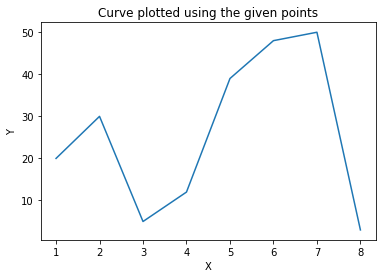

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
# Dataset
x = np.array([ 1,  2,  3,  4,  5,  6,  7, 8 ])
y = np.array([ 20, 30, 5, 12, 39, 48, 50, 3 ])
 
# Plotting the Graph
plt.plot(x, y)
plt.title("Curve plotted using the given points")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [ ]:
str = "x[0,3]"
taxi = int((str.split(',')[0]).split('[')[1])
print(taxi)
request = int((str.split(',')[1]).split(']')[0])
print(request)

print(type(taxi))
print(type(request))
print(taxi * request)

# total_pickup_time += pickup_time_in_mins[int((v.varName.split(',')[0]).split('[')[1]), int((v.varName.split(',')[1]).split(']')[0])]  

0
3
<class 'int'>
<class 'int'>
0
